In [2]:
import keras
# from tensorflow.keras import layers
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, LeakyReLU

from keras import callbacks
from keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.callbacks import ModelCheckpoint, EarlyStopping




%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

tf.Tensor(-49.81848, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# <font color=maroon>Model Building (Baseline) - VGG
   

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


### Build Transfer learning model

In [ ]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

In [ ]:
pre_model.trainable = False

In [ ]:
# build InceptionV3 model
model = Sequential(name='VGG_Baseline')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building (Tuned 1) - VGGT
   

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


### Data Preprocessing

In [3]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Changed Trainable = True
- Increased epoch size to 50
- Added Early Stopping
- Added lr scheduler

In [4]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [5]:
# pre_model.trainable = False
for layer in pre_model.layers:
    layer.trainable=True

In [6]:
# build InceptionV3 model
model = Sequential(name='VGG_Tuned_first1')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50


early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


model.summary()


def decay(epoch):
  return 0.001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]


model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                     callbacks=[early_stop, callback])

Model: "VGG_Tuned_first1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)          

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 20s 64ms/step - loss: 0.3914 - accuracy: 0.9153
Test loss:  0.39144572615623474
Test accuracy: 0.9153000116348267


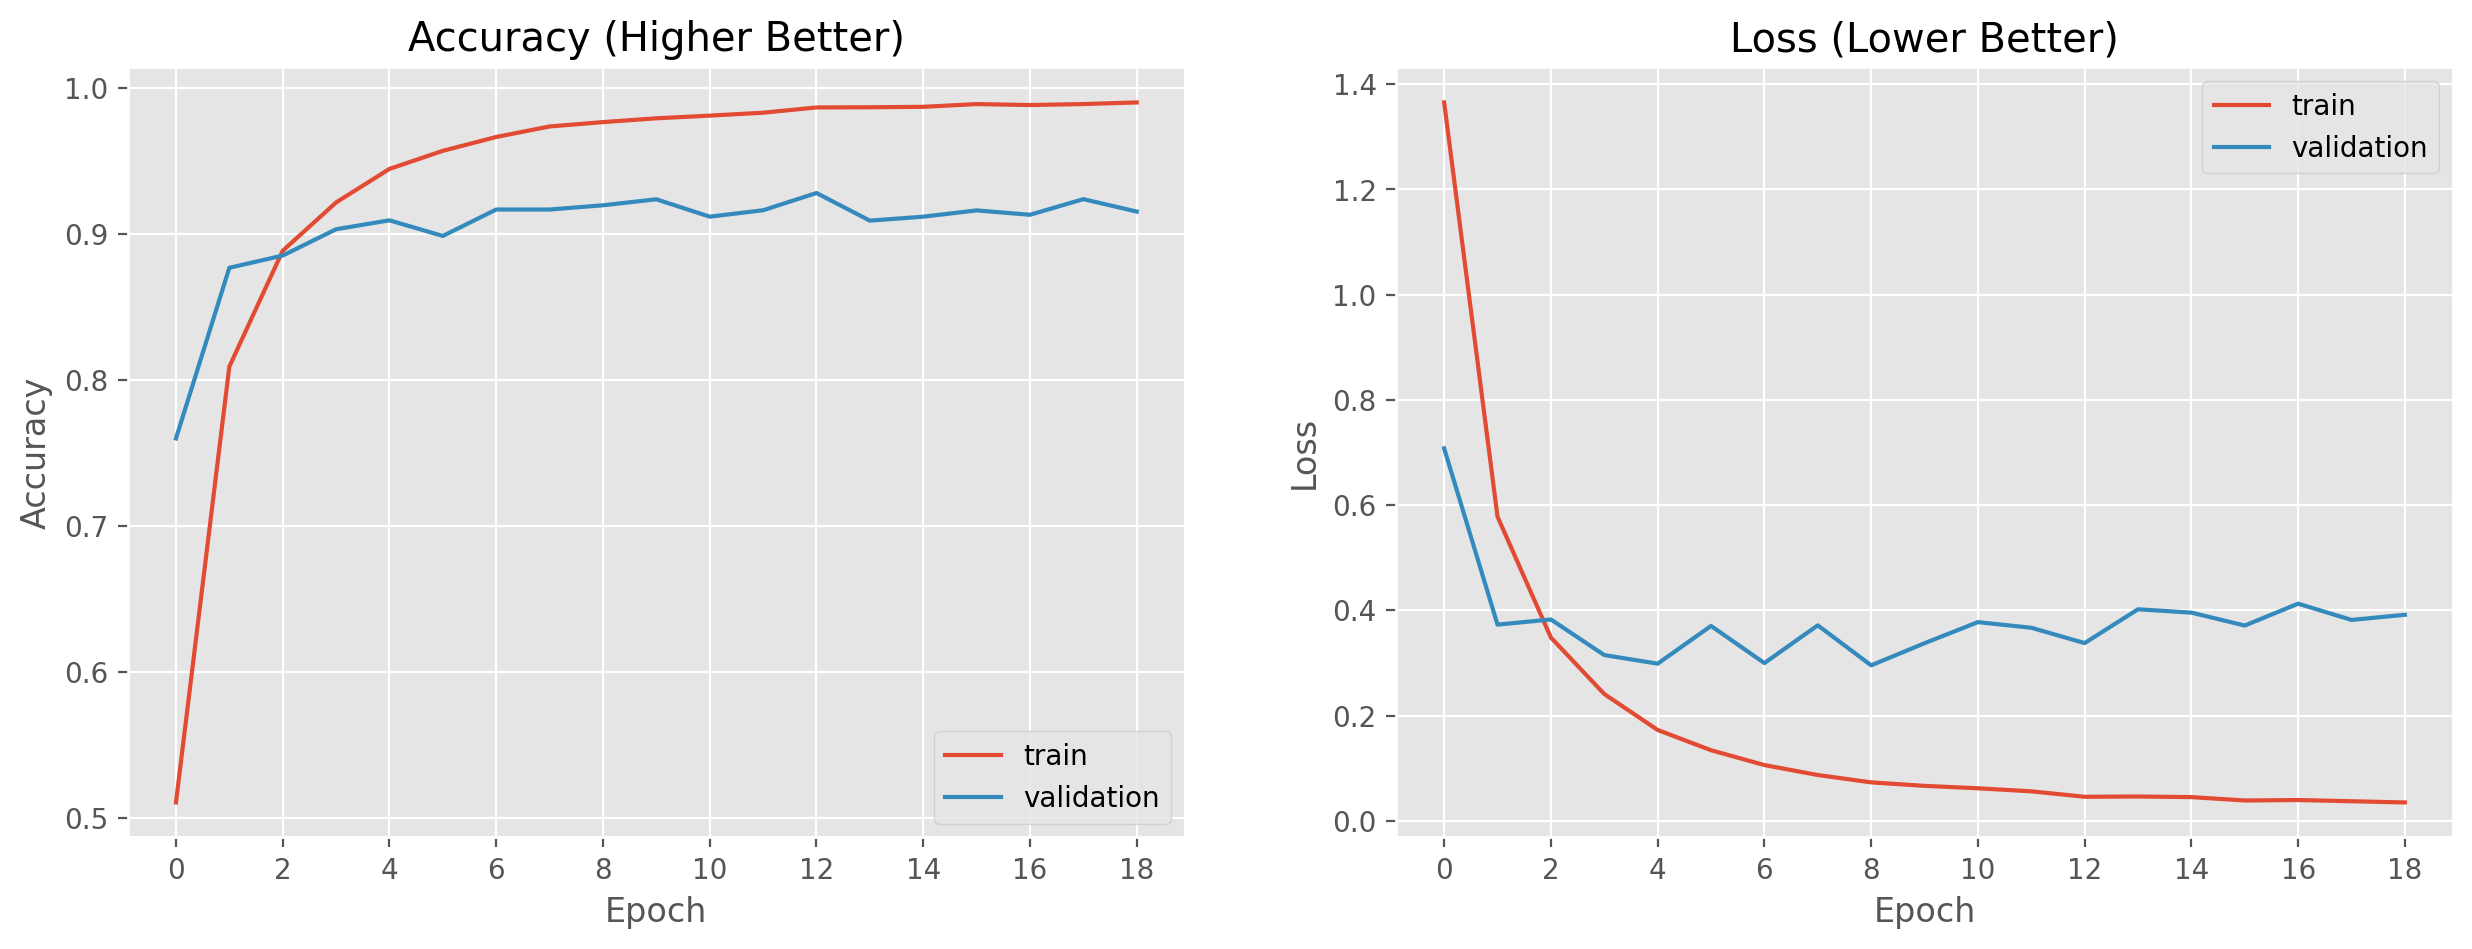

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 18s 58ms/step
[3 8 8 ... 5 1 7]


In [19]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [20]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [21]:
print(err_x.shape)

(1000, 32, 32, 3)


/tmp/ipykernel_31/2615009037.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


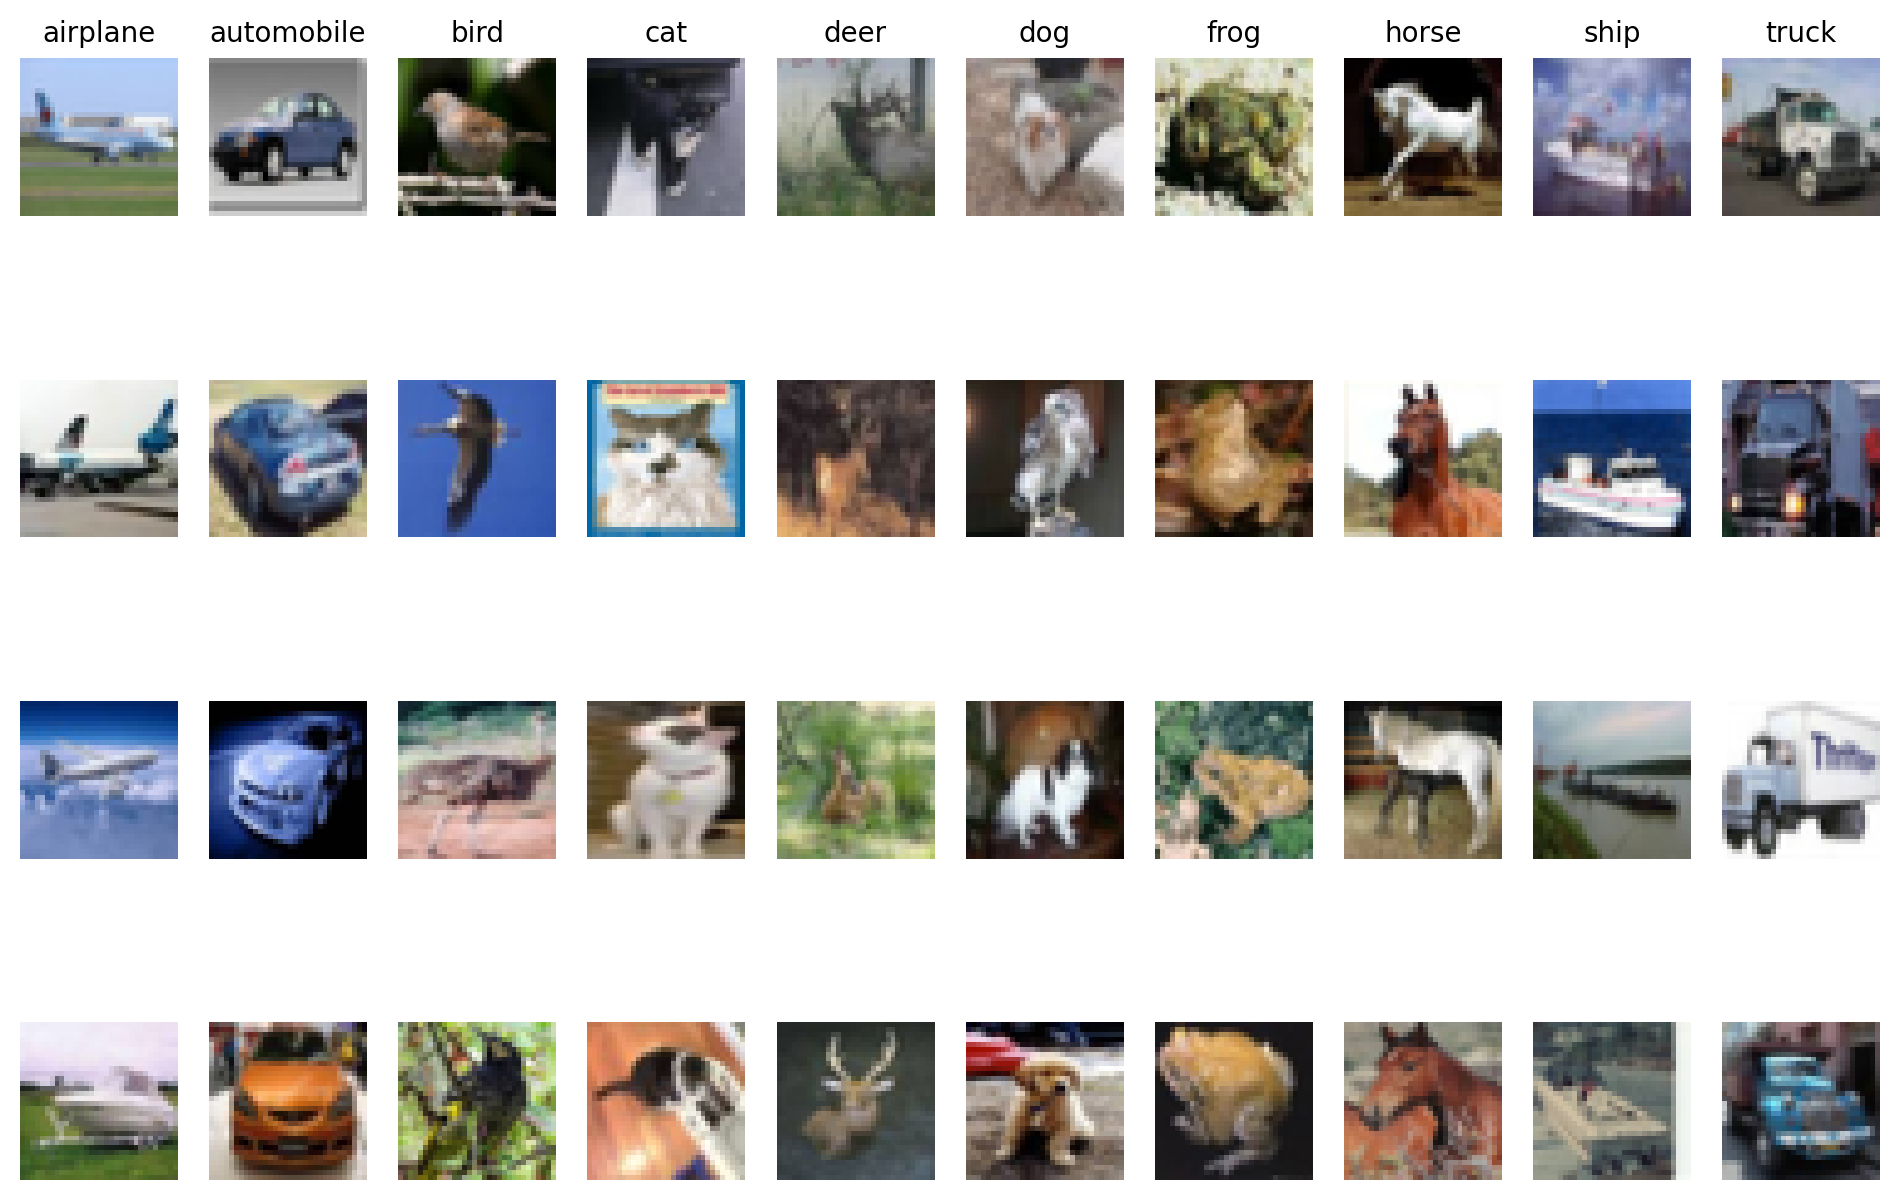

In [22]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building (Tuned 2) - VGG
   

### Import

In [3]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 12s 0us/step


### Data Preprocessing

In [4]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Changed Trainable = True
- Increased epoch size to 50
- Added Early Stopping
- Added lr scheduler
- Increased lr scheduler
- Used two dense layers with 4098 input shape 

In [5]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [6]:
# pre_model.trainable = False
for layer in pre_model.layers:
    layer.trainable=True

In [7]:
# build InceptionV3 model
model = Sequential(name='VGG_Tuned_2')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(10, activation='softmax'))

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50


early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


model.summary()


def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]


model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                     callbacks=[early_stop, callback])

Model: "VGG_Tuned_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 10)                40970     
                                                                 
Total params: 134,301,514
Trainable params: 134,301,514
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1563/1563 [===================

In [8]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 20s 65ms/step - loss: 0.4930 - accuracy: 0.9117
Test loss:  0.4929668605327606
Test accuracy: 0.9117000102996826


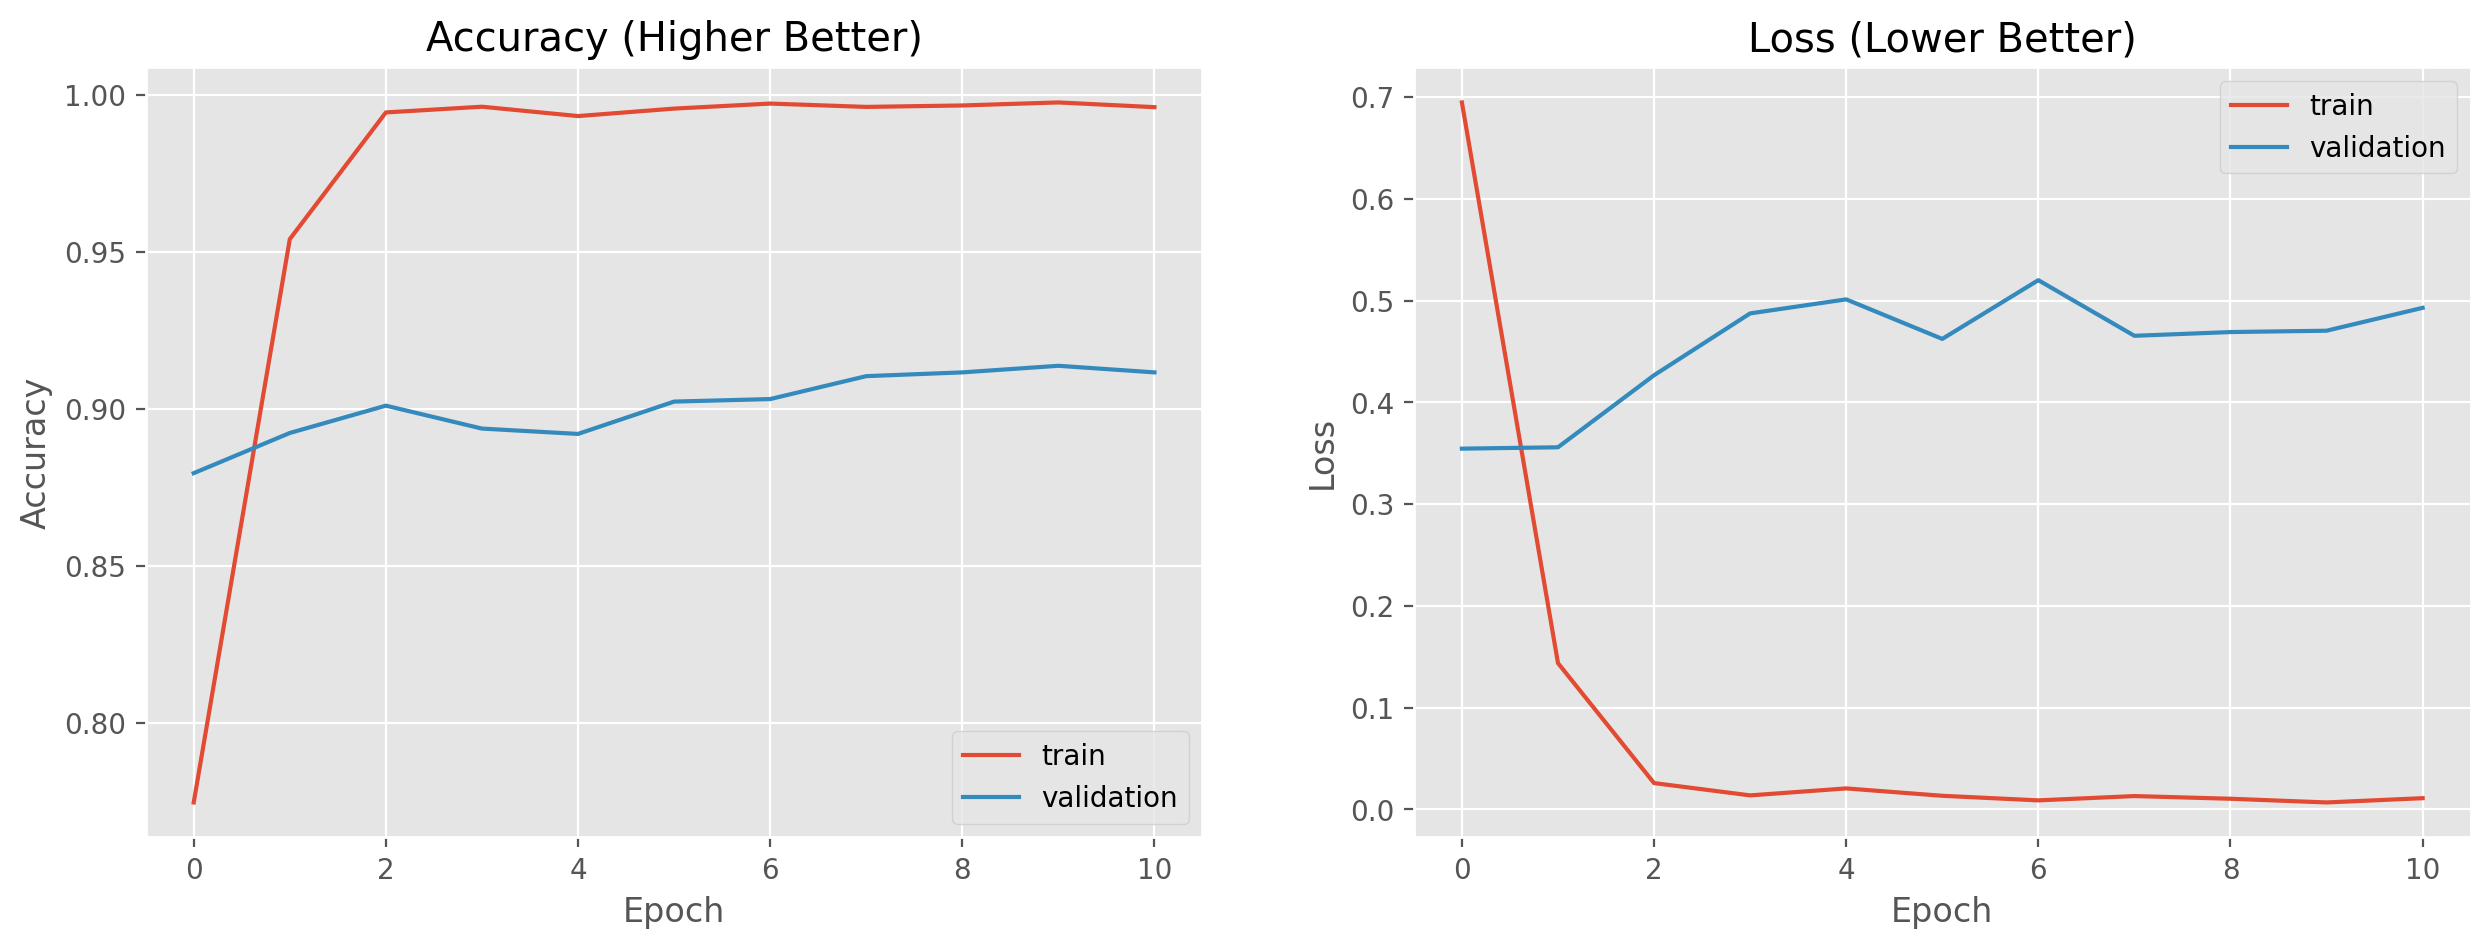

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [10]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 19s 59ms/step
[3 8 1 ... 5 1 7]


In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [12]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [13]:
print(err_x.shape)

(1000, 32, 32, 3)


/tmp/ipykernel_32/2615009037.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


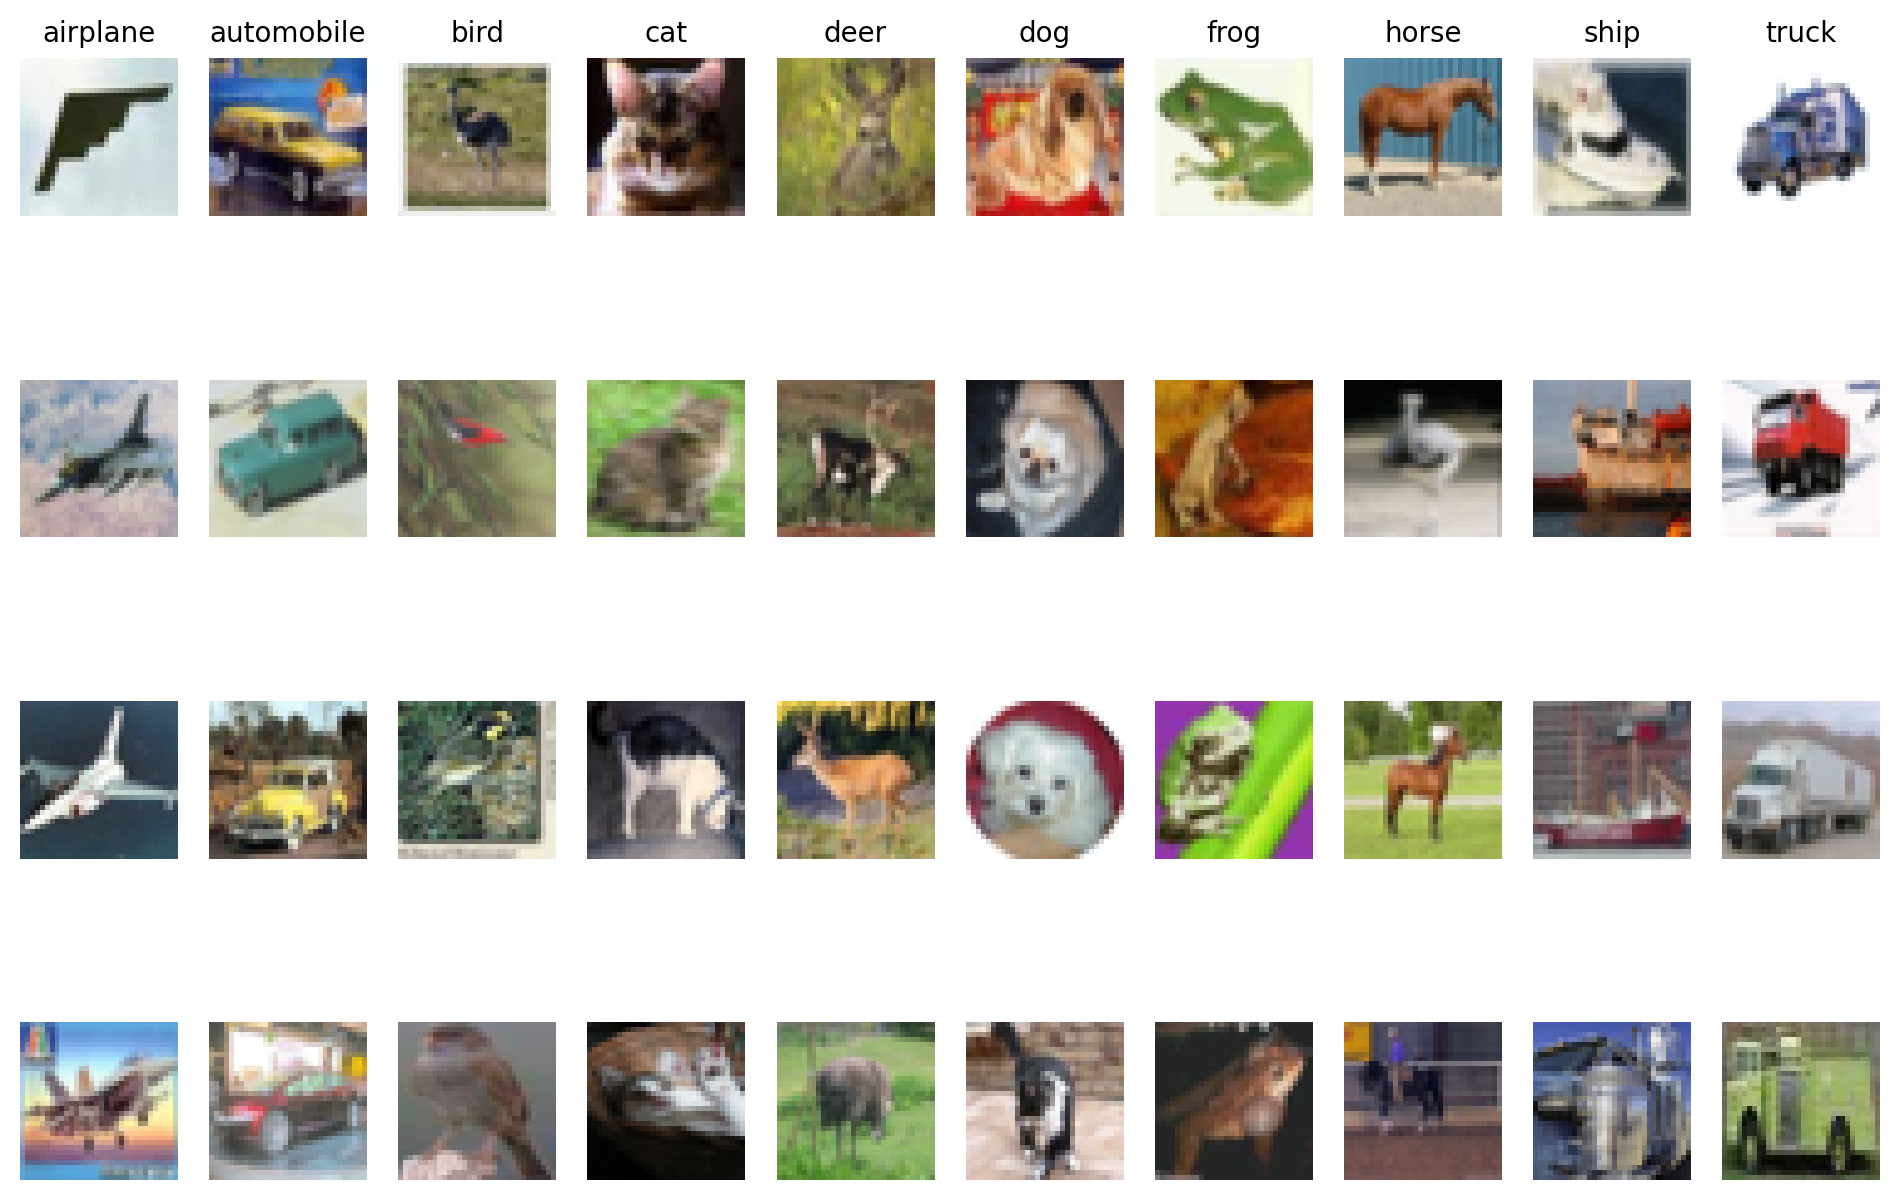

In [14]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building (Tuned 3) - VGG
   

### Import

In [15]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [16]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Changed Trainable = True
- Increased epoch size to 50
- Added Early Stopping
- Added lr scheduler
- Increased lr scheduler
- Used two dense layers with 4098 input shape 
- Added kernel regularisers
- Added dropout

In [17]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# pre_model.trainable = False
for layer in pre_model.layers:
    layer.trainable=True

In [19]:
# build InceptionV3 model
model = Sequential(name='VGG_Tuned_3')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50


early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


model.summary()


def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]


model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                     callbacks=[early_stop, callback])

Model: "VGG_Tuned_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                

In [20]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 20s 65ms/step - loss: 0.4120 - accuracy: 0.9232
Test loss:  0.412046879529953
Test accuracy: 0.9232000112533569


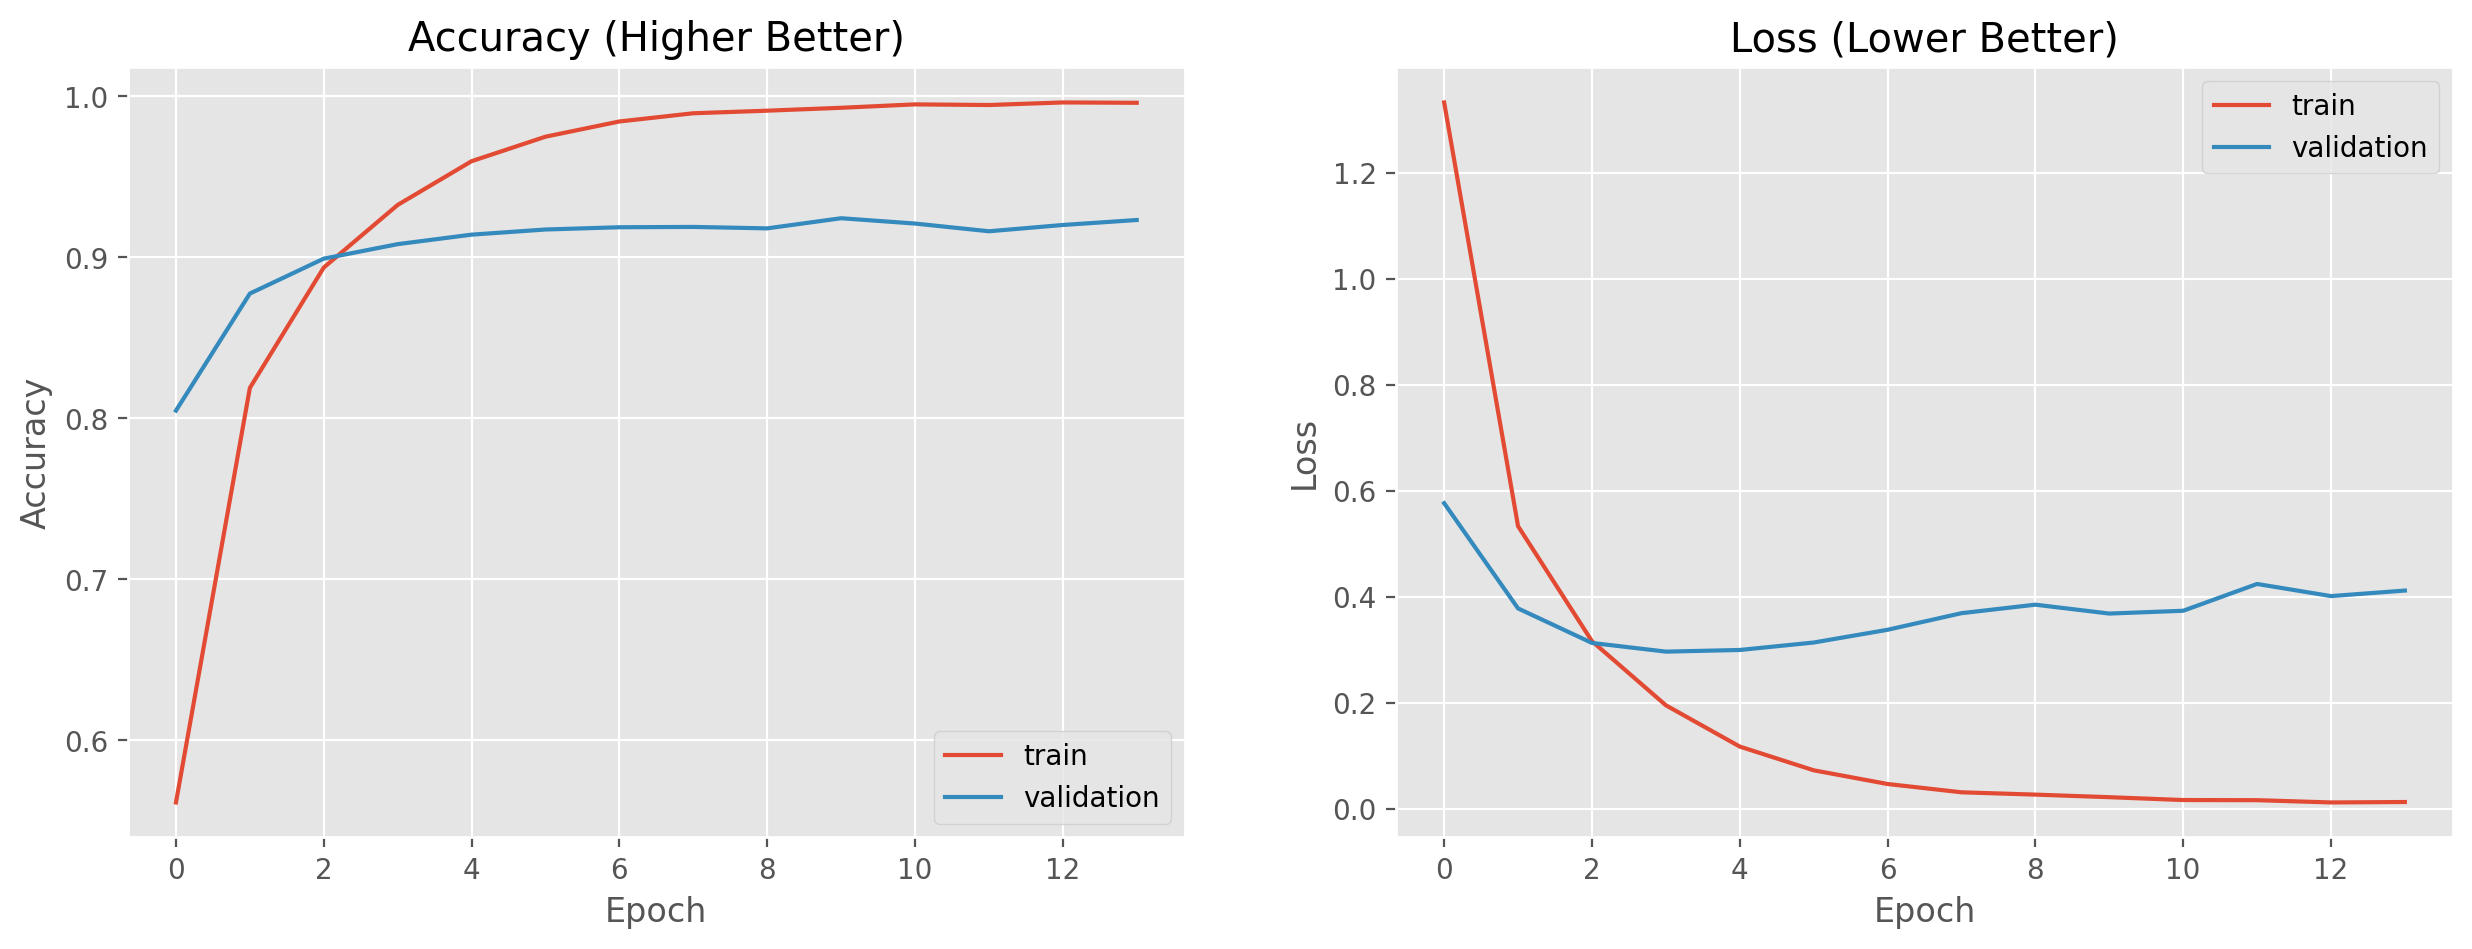

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [22]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 19s 60ms/step
[3 8 8 ... 5 1 7]


In [23]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [24]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [25]:
print(err_x.shape)

(1000, 32, 32, 3)


In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)

/tmp/ipykernel_32/3077457731.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


# <font color=maroon>Model Building (Tuned 4) - VGG
   

### Import

In [27]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [28]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Changed Trainable = True
- Increased epoch size to 50
- Added Early Stopping
- Added lr scheduler
- Increased lr scheduler
- Used two dense layers with 4098 input shape 
- Added kernel regularisers
- Added dropout
- Increased Dropout

In [29]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
# pre_model.trainable = False
for layer in pre_model.layers:
    layer.trainable=True

In [ ]:
# build InceptionV3 model
model = Sequential(name='VGG_Tuned_4')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50


early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


model.summary()


def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]


model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                     callbacks=[early_stop, callback])

Model: "VGG_Tuned_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 4096)              102764544 
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)